In [19]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras_preprocessing import image

from keras_preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98):
      print("\nReached 97.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [49]:
TRAINING_DIR = './img/train/'
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      brightness_range = [0.2,1.0],
      fill_mode='nearest')
VALIDATION_DIR = './img/val/'
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

model = keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    # The third convolution
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    keras.layers.Conv2D(256, (2,2), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    # The sixth convolution
    keras.layers.Conv2D(256, (2,2), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])


model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_generator, epochs=20, steps_per_epoch=100, validation_data = validation_generator, verbose = 1, validation_steps=50, callbacks = [myCallback()])

model.save("chairmodel.h5")

Found 2700 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 17, 17, 128)       0         
_____________________________________

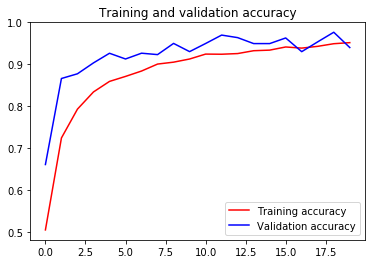

<Figure size 432x288 with 0 Axes>

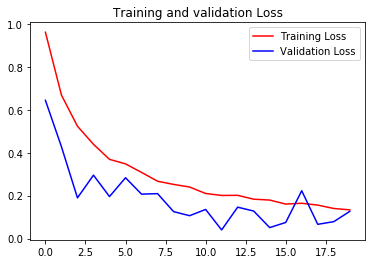

<Figure size 432x288 with 0 Axes>

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [51]:
np.save('model_history.npy', history.history)
# history = np.load('model_history.npy', allow_pickle = 'TRUE').item()

In [32]:
loaded_model = keras.models.load_model('chairmodel.h5')

In [33]:
path = './swivel_chair.jpg'
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# images = np.vstack([x])
classes = loaded_model.predict(x)
print(classes)

[[0. 0. 1.]]


In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3632729426476400804
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17130957797228819598
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16621303720368214271
physical_device_desc: "device: XLA_GPU device"
]


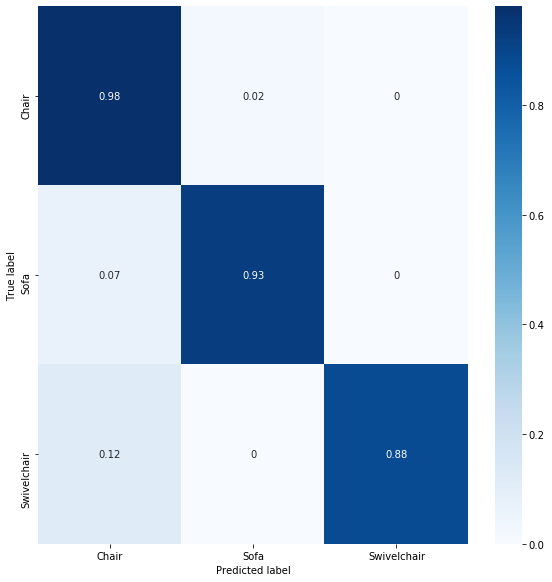

In [53]:
y_pred = loaded_model.predict(validation_generator)
# print(y_pred)
y_pred = np.argmax(y_pred, axis=1)
# print('Confusion Matrix')

# print('Classification Report')
# target_names = ['Chair', 'Sofa', 'Swivelchair']
# print(classification_report(validation_generator.classes, y_pred, target_names=target_names))
con_mat = confusion_matrix(validation_generator.classes, y_pred)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = ['Chair', 'Sofa', 'Swivelchair'], 
                     columns = ['Chair', 'Sofa', 'Swivelchair'])
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [40]:
import tensorflow as tf
import seaborn as sns

In [48]:
print(confusion_matrix(train_generator.classes, y_pred))

[[305 306 289]
 [313 313 274]
 [308 305 287]]


In [52]:
validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126,
    shuffle=False
)

Found 300 images belonging to 3 classes.
